In [20]:
from qresearch.portfolio.weights import TopKConfig, build_topk_weights
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Literal, Tuple, Optional


def momentum_scores(prices: pd.DataFrame, lookback: int = 20) -> pd.DataFrame:
    """
    Simple lookback return as score: price / price.shift(lookback) - 1
    scores aligned to prices index/cols.
    """
    px = prices.replace([np.inf, -np.inf], np.nan)
    score = px / px.shift(lookback) - 1.0
    score = score.replace([np.inf, -np.inf], np.nan)
    return score

### 下载指数数据

In [ ]:
import akshare as ak

stock_zh_index_spot_em_df = ak.stock_zh_index_spot_em(symbol="沪深重要指数")
print(stock_zh_index_spot_em_df)

### 大小盘与成长价值
- 创业板指数可作为成长指数，上证50作为价值指数

In [76]:
INDEX_SMALL = {
    '000852': 'CSI1000',
    '000905': 'CSI500',
    '399006': 'ChiNext',
}

INDEX_LARGE = {
    '000300': 'CSI300',
    '000016': 'CSI50',
}

INDEX = INDEX_SMALL | INDEX_LARGE
TICK_TO_NAME_MAP = {v: k for k, v in INDEX.items()}

def build_pair_prices(df_map: dict, large: str, small: str) -> pd.DataFrame:
    """
    df_map[name] is an AKShare index hist df with columns including: '日期', '收盘', etc.
    Return a 2-col close price DataFrame indexed by Date with columns [large, small].
    """
    if large not in df_map or small not in df_map:
        raise KeyError(f"Missing in df_map: {large if large not in df_map else ''} {small if small not in df_map else ''}")

    dfl = df_map[large].copy()
    dfs = df_map[small].copy()

    # normalize date
    dfl["Date"] = pd.to_datetime(dfl["日期"])
    dfs["Date"] = pd.to_datetime(dfs["日期"])

    # keep close only (AKShare uses '收盘')
    dfl = dfl[["Date", "收盘"]].rename(columns={"收盘": large})
    dfs = dfs[["Date", "收盘"]].rename(columns={"收盘": small})

    # inner join on common trading days
    px = dfl.merge(dfs, how="inner", on="Date").set_index("Date").sort_index()

    # enforce numeric
    px[large] = pd.to_numeric(px[large], errors="coerce")
    px[small] = pd.to_numeric(px[small], errors="coerce")
    px = px.dropna()

    return px

In [8]:
df_map = {}

for k, v in INDEX.items():
    tmp_df = ak.index_zh_a_hist(symbol=k, period="daily", start_date="20000101", end_date="20260123")
    df_map[v] = tmp_df

  0%|          | 0/16 [00:00<?, ?it/s]

### 选择大小盘

In [95]:
LARGE, SMALL = 'CSI50', 'ChiNext'
df_combined = df_map[LARGE].merge(df_map[SMALL], how='inner', on='日期')
prices = df_combined[['日期', '收盘_x', '收盘_y']].copy()
prices.rename(columns={
    '收盘_x': LARGE,
    '收盘_y': SMALL,
    '日期': 'Date'
}, inplace=True)
prices.set_index('Date', inplace=True)
prices.index = pd.to_datetime(prices.index)

                   Strategy    Benchmark
ann_return_geo     0.164327     0.066730
ann_vol            0.233284     0.231684
sharpe             0.768549     0.394988
max_dd            -0.484725    -0.524352
n_obs           3802.000000  3802.000000
Date
2010    0.073885
2011   -0.103124
2012    0.123460
2013    0.138384
2014    0.921040
2015    0.887657
2016   -0.265044
2017    0.065839
2018   -0.186476
2019    0.331838
2020    0.350322
2021    0.262844
2022    0.098039
2023   -0.149177
2024    0.215272
2025    0.327383
2026    0.019085
dtype: float64


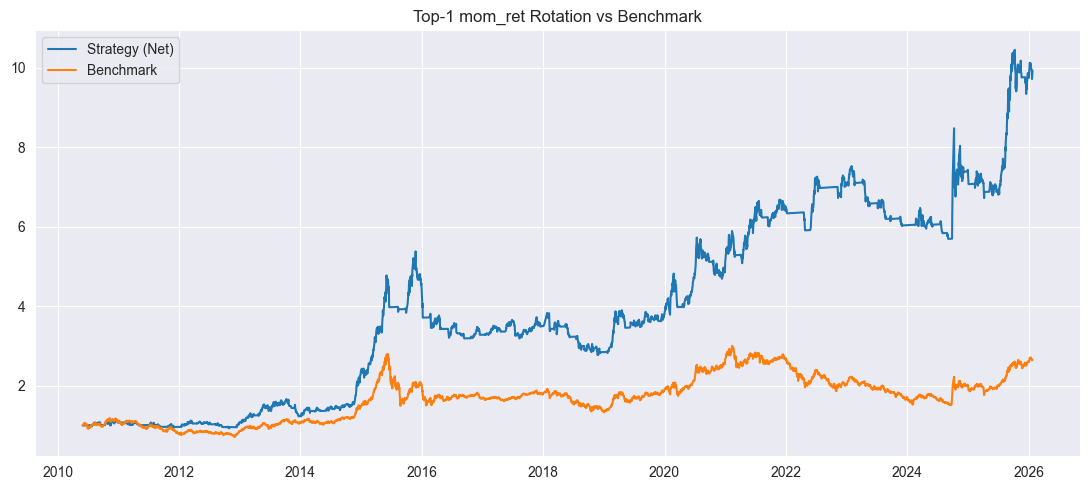

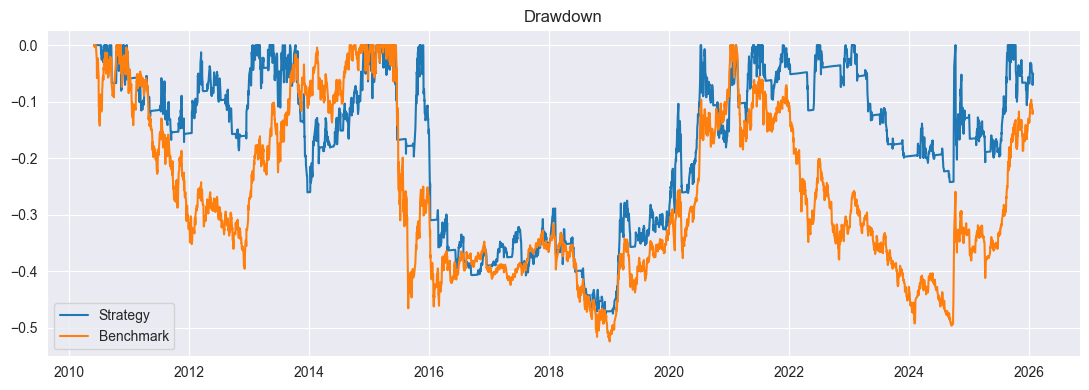

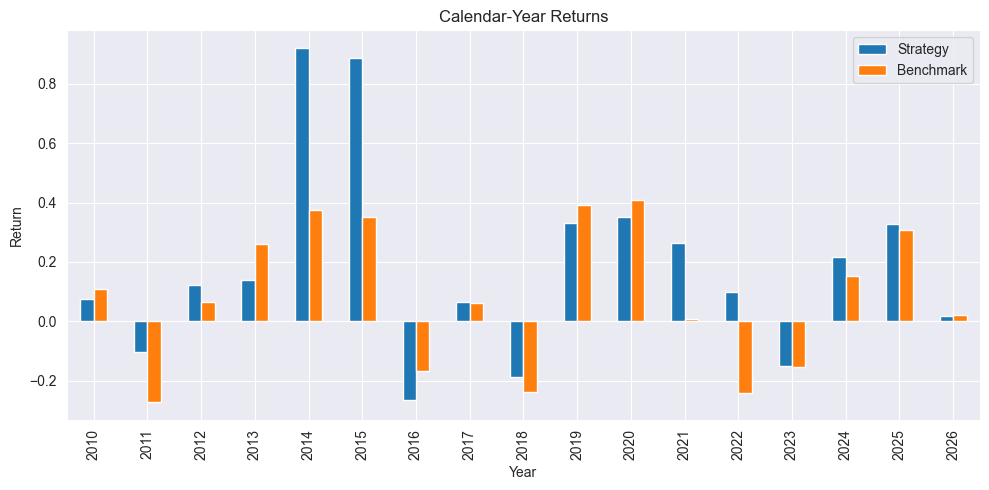

In [98]:
from qresearch.backtest.portfolio import backtest_weights
from typing import Any, Dict
from dataclasses import field
from matplotlib import pyplot as plt
from qresearch.backtest.metrics import perf_summary, TRADING_DAYS, drawdown_series_from_equity, yearly_returns

RebalanceMode = Literal["calendar", "fixed_h"]


# 数据开始时间为 "2005-01-04"，但是2010年前市场不成熟，所以设置开始时间为2010之后

@dataclass(frozen=True)
class ExperimentConfig:
    start: str = "2010-01-01"
    end: Optional[str] = None
    
    # schedule
    rebalance_mode: RebalanceMode = "fixed_h"
    rebalance: str = "W-FRI"     # used if calendar
    H: int = 5                   # used if fixed_h
    offset: int = 0

    top_k: int = 1
    fee_bps: float = 2.0

    benchmark_mode: Literal["equal_weight_all", "single_ticker"] = "single_ticker"
    benchmark_ticker: Optional[str] = None
    rf_annual: float = 0.0

    # registry-style
    signal_name: str = "mom_ret"
    signal_params: Dict[str, Any] = field(default_factory=lambda: {"lookback": 21, "skip": 0})


def build_benchmark_weights(prices: pd.DataFrame, cfg: ExperimentConfig) -> pd.DataFrame:
    cols = prices.columns.tolist()

    if cfg.benchmark_mode == "equal_weight_all":
        w = pd.Series(1.0 / len(cols), index=cols)
        return pd.DataFrame(np.tile(w.values, (len(prices), 1)), index=prices.index, columns=cols)

    if cfg.benchmark_mode == "single_ticker":
        if not cfg.benchmark_ticker or cfg.benchmark_ticker not in cols:
            raise ValueError("benchmark_ticker must be in prices.columns")
        w = pd.Series(0.0, index=cols)
        w[cfg.benchmark_ticker] = 1.0
        return pd.DataFrame(np.tile(w.values, (len(prices), 1)), index=prices.index, columns=cols)

    raise ValueError(f"Unknown benchmark_mode: {cfg.benchmark_mode}")


def plot_compare(eq_s: pd.Series, eq_b: pd.Series, ret_s: pd.Series, ret_b: pd.Series, title: str) -> None:
    # equity
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(eq_s.index, eq_s.values, label="Strategy (Net)")
    ax.plot(eq_b.index, eq_b.values, label="Benchmark")
    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    plt.show()

    # drawdown
    dd_s = drawdown_series_from_equity(eq_s)
    dd_b = drawdown_series_from_equity(eq_b)
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.plot(dd_s.index, dd_s.values, label="Strategy")
    ax.plot(dd_b.index, dd_b.values, label="Benchmark")
    ax.set_title("Drawdown")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # yearly returns
    yr_s = yearly_returns(ret_s).rename("Strategy")
    yr_b = yearly_returns(ret_b).rename("Benchmark")
    yr_tbl = pd.concat([yr_s, yr_b], axis=1).sort_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    yr_tbl.plot(kind="bar", ax=ax)
    ax.set_title("Calendar-Year Returns")
    ax.set_ylabel("Return")
    ax.set_xlabel("Year")
    fig.tight_layout()
    plt.show()


def run_one(close_df, scores, cfg: ExperimentConfig) -> dict:
    # 2) weights (library)
    wcfg = TopKConfig(
        mode=cfg.rebalance_mode,    # "calendar" or "fixed_h"
        rebalance=cfg.rebalance,    # used only when mode="calendar"
        H=cfg.H,                    # used only when mode="fixed_h"
        offset=cfg.offset,          # used only when mode="fixed_h"
        top_k=cfg.top_k,
        use_absolute_filter=True,
    )
    w_strat = build_topk_weights(prices=close_df, scores=scores, cfg=wcfg)

    # 3) backtest (library engine)
    strat = backtest_weights(
        prices=close_df,
        weights=w_strat,         # unshifted decision-time weights
        fee_bps=cfg.fee_bps,
        rf_annual=cfg.rf_annual,
        long_only=True,
        allow_leverage=False,
        max_gross=1.01,
    )

    # 4) benchmark weights + backtest
    w_bench = build_benchmark_weights(close_df, cfg)
    bench = backtest_weights(
        prices=close_df,
        weights=w_bench,
        fee_bps=0.0,
        rf_annual=cfg.rf_annual,
        long_only=True,
        allow_leverage=False,
        max_gross=1.01,
    )

    # 5) standardized stats (use returns, not equity-only)
    stats_s = pd.Series(perf_summary(strat.net_ret, freq=TRADING_DAYS), name="Strategy")
    stats_b = pd.Series(perf_summary(bench.net_ret, freq=TRADING_DAYS), name="Benchmark")

    return {
        "cfg": cfg,
        "scores": scores,
        "weights_strategy": w_strat,
        "weights_benchmark": w_bench,
        "strat": strat,
        "bench": bench,
        "stats": pd.concat([stats_s, stats_b], axis=1),
    }

def _compound(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return float((1.0 + r).prod() - 1.0)

cfg = ExperimentConfig(
    H=5,
    top_k=1,
    fee_bps=2.0,
    benchmark_mode="equal_weight_all",
    rf_annual=0.015
)

# market_data = download_market_data(tickers, start=cfg.start, end=cfg.end)
price_df = prices[prices.index >= cfg.start]

scores = momentum_scores(price_df, lookback=20)

out = run_one(price_df, scores=scores, cfg=cfg)
print(out["stats"])
print(yearly_returns(out['strat'].net_ret))

plot_compare(
    eq_s=out["strat"].equity_net,
    eq_b=out["bench"].equity_net,
    ret_s=out["strat"].net_ret,
    ret_b=out["bench"].net_ret,
    title=f"Top-{cfg.top_k} {cfg.signal_name} Rotation vs Benchmark",
)


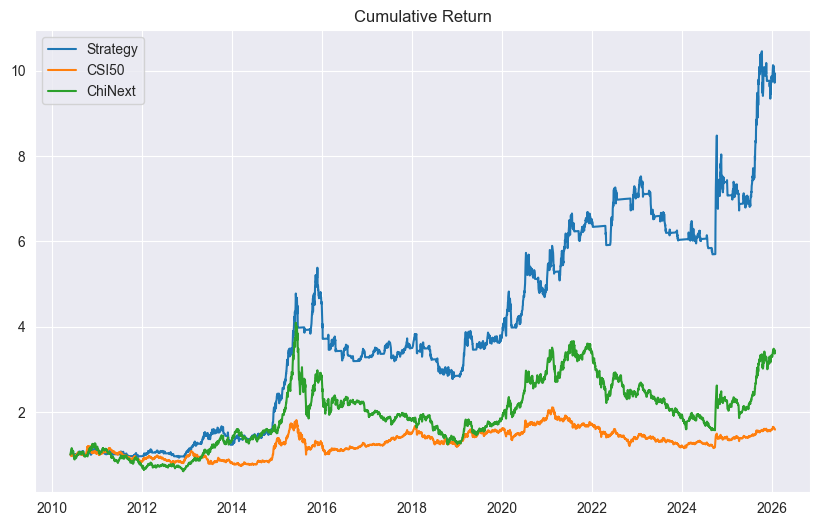

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(out['strat'].equity_net, label='Strategy')
plt.plot(price_df / price_df.iloc[0], label=[LARGE, SMALL])
plt.title('Cumulative Return')
plt.legend()
plt.show()

### 不同大小盘股指数回测

In [80]:
def run_pair(df_map: dict, large: str, small: str, cfg: ExperimentConfig, lookback: int = 20) -> dict:
    prices_pair = build_pair_prices(df_map, large, small)

    # apply date range from cfg
    start = pd.Timestamp(cfg.start)
    end = pd.Timestamp(cfg.end) if cfg.end else None
    if end is None:
        prices_pair = prices_pair.loc[prices_pair.index >= start]
    else:
        prices_pair = prices_pair.loc[(prices_pair.index >= start) & (prices_pair.index <= end)]

    scores = momentum_scores(prices_pair, lookback=lookback)

    out = run_one(prices_pair, scores=scores, cfg=cfg)

    # add a few diagnostics that are very useful when comparing pairs
    res = out["strat"]
    row = {
        "LARGE": large,
        "SMALL": small,
        "n_obs": len(res.net_ret),
        "ann_return_geo": float(out["stats"].loc["ann_return_geo", "Strategy"]),
        "ann_vol": float(out["stats"].loc["ann_vol", "Strategy"]),
        "sharpe": float(out["stats"].loc["sharpe", "Strategy"]),
        "max_dd": float(out["stats"].loc["max_dd", "Strategy"]),
        "total_return": float(res.equity_net.iloc[-1] - 1.0),
        "turnover_mean": float(res.turnover.mean()),
        "cash_ratio": float((res.exposure < 1e-9).mean()),
    }
    return {"row": row, "out": out, "prices": prices_pair}

def sweep_pairs(df_map: dict,
                large_list: list[str],
                small_list: list[str],
                cfg: ExperimentConfig,
                lookback: int = 20,
                drop_same: bool = True) -> pd.DataFrame:
    rows = []
    for L in large_list:
        for S in small_list:
            if drop_same and L == S:
                continue
            try:
                out = run_pair(df_map, L, S, cfg=cfg, lookback=lookback)
                rows.append(out["row"])
            except Exception as e:
                rows.append({
                    "LARGE": L, "SMALL": S,
                    "error": str(e),
                })
    df = pd.DataFrame(rows)
    if "sharpe" in df.columns:
        df = df.sort_values(["sharpe", "ann_return_geo"], ascending=False, na_position="last")
    return df

large_list = list(INDEX_LARGE.values())   # ['CSI300', 'CSI50']
small_list = list(INDEX_SMALL.values())   # ['CSI1000', 'CSI500', 'ChiNext']

cfg = ExperimentConfig(
    start="2005-01-04",
    end=None,
    H=1,
    top_k=1,
    fee_bps=2.0,
    benchmark_mode="equal_weight_all",
    rf_annual=0.015
)

df_pairs = sweep_pairs(df_map, large_list, small_list, cfg=cfg, lookback=20)
print(df_pairs)

    LARGE    SMALL  n_obs  ann_return_geo   ann_vol    sharpe    max_dd  \
3   CSI50  CSI1000   5116        0.290896  0.219454  1.274353 -0.279648   
0  CSI300  CSI1000   5116        0.271678  0.211675  1.242353 -0.289159   
1  CSI300   CSI500   5116        0.233840  0.203547  1.135129 -0.359527   
4   CSI50   CSI500   5116        0.232691  0.211884  1.094242 -0.354919   
2  CSI300  ChiNext   3802        0.215342  0.222263  0.988234 -0.320420   
5   CSI50  ChiNext   3802        0.220664  0.229147  0.984453 -0.281755   

   total_return  turnover_mean  cash_ratio  
3    177.347467       0.156568    0.325841  
0    130.529337       0.149922    0.356919  
1     70.236063       0.155395    0.375098  
4     68.900890       0.162823    0.343432  
2     17.961456       0.158601    0.365334  
5     19.253592       0.149132    0.333509  


### 收益归因：到底是“少数牛市段贡献”还是“长期稳定小幅赚钱”

In [37]:
def _logret(r: pd.Series) -> pd.Series:
    r = r.fillna(0.0).replace([np.inf, -np.inf], 0.0)
    return np.log1p(r)

def _ann_geo_from_logsum(logsum: float, n_days: int, trading_days: int = 252) -> float:
    if n_days <= 0:
        return np.nan
    return float(np.exp(logsum * (trading_days / n_days)) - 1.0)

def _simple_from_logsum(logsum: float) -> float:
    return float(np.exp(logsum) - 1.0)

def attribution_by_year(net_ret: pd.Series, trading_days: int = 252) -> pd.DataFrame:
    g = _logret(net_ret)
    yr = g.groupby(g.index.year).sum()
    total = yr.sum()

    out = pd.DataFrame({
        "log_sum": yr,
        "simple_return": yr.apply(_simple_from_logsum),
        "share_of_total_log": yr / total if total != 0 else np.nan,
    })
    out.index.name = "year"
    out = out.sort_values("log_sum", ascending=False)
    return out

def top_rolling_windows(net_ret: pd.Series, window: int = 252, top_n: int = 10) -> pd.DataFrame:
    g = _logret(net_ret)
    roll = g.rolling(window).sum()

    # top windows by log-sum
    top_end = roll.nlargest(top_n).index
    rows = []
    for end in top_end:
        start = g.index[g.index.get_loc(end) - window + 1]
        logsum = float(roll.loc[end])
        rows.append({
            "start": start,
            "end": end,
            "log_sum": logsum,
            "simple_return": _simple_from_logsum(logsum),
        })
    return pd.DataFrame(rows).sort_values("log_sum", ascending=False)

def state_contribution(weights_used: pd.DataFrame, net_ret: pd.Series, eps: float = 1e-9, trading_days: int = 252) -> pd.DataFrame:
    # align
    w = weights_used.reindex(net_ret.index).fillna(0.0)
    r = net_ret.reindex(w.index).fillna(0.0)

    exposure = w.sum(axis=1)
    # state label: CASH if exposure~0 else argmax weight ticker
    state = pd.Series(index=w.index, dtype="object")
    state[exposure < eps] = "CASH"
    active = exposure >= eps
    if active.any():
        state.loc[active] = w.loc[active].idxmax(axis=1)

    g = _logret(r)
    df = pd.DataFrame({"state": state, "log_g": g, "ret": r})
    grp = df.groupby("state")

    out = pd.DataFrame({
        "days": grp.size(),
        "mean_daily_ret": grp["ret"].mean(),
        "log_sum": grp["log_g"].sum(),
    })
    out["simple_return"] = out["log_sum"].apply(_simple_from_logsum)
    out["share_of_total_log"] = out["log_sum"] / out["log_sum"].sum() if out["log_sum"].sum() != 0 else np.nan
    out["ann_geo_in_state"] = out.apply(lambda row: _ann_geo_from_logsum(row["log_sum"], int(row["days"]), trading_days), axis=1)

    return out.sort_values("log_sum", ascending=False)


In [41]:
yr_attr = attribution_by_year(out["strat"].net_ret)
print(yr_attr.head(15))
print("Top-4 years share (log):", float(yr_attr["share_of_total_log"].head(4).sum()))

top_win = top_rolling_windows(out["strat"].net_ret, window=252, top_n=12)
print(top_win)

state_attr = state_contribution(out["strat"].weights_used, out["strat"].net_ret)
print(state_attr)

       log_sum  simple_return  share_of_total_log
year                                             
2007  0.964899       1.624524            0.226184
2006  0.909501       1.483084            0.213198
2009  0.747806       1.112361            0.175294
2015  0.627209       0.872377            0.147025
2014  0.499344       0.647640            0.117052
2019  0.307469       0.359978            0.072074
2025  0.233590       0.263126            0.054756
2010  0.154192       0.166715            0.036144
2017  0.141210       0.151666            0.033101
2026  0.140317       0.150638            0.032892
2024  0.118068       0.125321            0.027677
2012  0.102896       0.108377            0.024120
2020  0.045120       0.046153            0.010577
2021  0.034058       0.034644            0.007983
2005  0.017017       0.017163            0.003989
Top-4 years share (log): 0.7617009958800052
        start        end   log_sum  simple_return
0  2006-04-21 2007-05-10  1.519108       3.568150
1  200

In [40]:
def zero_out_windows(net_ret: pd.Series, windows: list[tuple[str, str]]) -> pd.Series:
    r = net_ret.copy()
    for s, e in windows:
        mask = (r.index >= pd.Timestamp(s)) & (r.index <= pd.Timestamp(e))
        r.loc[mask] = 0.0
    return r

def quick_stats(net_ret: pd.Series, trading_days: int = 252) -> dict:
    g = _logret(net_ret)
    logsum = float(g.sum())
    n = int(g.shape[0])
    ann_geo = _ann_geo_from_logsum(logsum, n, trading_days)
    vol = float(net_ret.std() * np.sqrt(trading_days))
    sharpe = float((net_ret.mean() / (net_ret.std() + 1e-12)) * np.sqrt(trading_days))
    eq = (1.0 + net_ret.fillna(0.0)).cumprod()
    dd = (eq / eq.cummax() - 1.0).min()
    return {"ann_geo": ann_geo, "ann_vol": vol, "sharpe": sharpe, "max_dd": float(dd), "total_return": float(eq.iloc[-1] - 1.0)}

# Example windows: replace with your true 4 segments
windows = [
    ("2006-04-01", "2007-12-31"),
    ("2009-01-01", "2011-12-31"),
    ("2015-01-01", "2015-12-31"),
    ("2024-01-01", "2099-12-31"),
]

r_ex = zero_out_windows(out["strat"].net_ret, windows)
print("Original:", quick_stats(out["strat"].net_ret))
print("Exclude windows:", quick_stats(r_ex))


Original: {'ann_geo': 0.233840068048202, 'ann_vol': 0.2035665666965621, 'sharpe': 1.1350175827912643, 'max_dd': -0.35952721378307373, 'total_return': 70.23606258963925}
Exclude windows: {'ann_geo': 0.026987728453736315, 'ann_vol': 0.134669257872443, 'sharpe': 0.26547799069705064, 'max_dd': -0.3595272137830743, 'total_return': 0.7170898383266378}


### 参数敏感度测试

In [44]:
def run_rotation_once(
    prices: pd.DataFrame,
    lookback: int,
    mode: str,
    H: int = 1,
    rebalance: str = "W-FRI",
    fee_bps: float = 2.0,
    rf_annual: float = 0.015,
    top_k: int = 1,
    use_absolute_filter: bool = True,
) -> dict:
    # scores
    scores = momentum_scores(prices, lookback=lookback)

    # weights
    wcfg = TopKConfig(
        mode=mode,
        rebalance=rebalance,
        H=H,
        offset=0,
        top_k=top_k,
        use_absolute_filter=use_absolute_filter,
    )
    w = build_topk_weights(prices=prices, scores=scores, cfg=wcfg)

    # backtest
    bt = backtest_weights(
        prices=prices,
        weights=w,
        fee_bps=fee_bps,
        rf_annual=rf_annual,
        long_only=True,
        allow_leverage=False,
        max_gross=1.01,
    )

    # metrics
    r = bt.net_ret
    eq = bt.equity_net
    dd = (eq / eq.cummax() - 1.0).min()

    out = {
        "lookback": lookback,
        "mode": mode,
        "H": H if mode == "fixed_h" else np.nan,
        "rebalance": rebalance if mode == "calendar" else None,
        "ann_geo": quick_stats(r)["ann_geo"],
        "ann_vol": float(r.std() * np.sqrt(TRADING_DAYS)),
        "sharpe": float((r.mean() / (r.std() + 1e-12)) * np.sqrt(TRADING_DAYS)),
        "max_dd": float(dd),
        "turnover_mean": float(bt.turnover.mean()),
        "cash_ratio": float((bt.exposure < 1e-9).mean()),
        "total_return": float(bt.equity_net.iloc[-1] - 1.0),
    }
    return out

def robustness_sweep(
    prices: pd.DataFrame,
    lookbacks=(10, 20, 40, 60, 120),
    fixed_Hs=(1, 5, 10, 20),
    calendar_freqs=("W-FRI", "M"),
    fee_bps: float = 2.0,
    use_absolute_filter: bool = True,
) -> pd.DataFrame:
    rows = []

    # fixed_h sweeps
    for lb in lookbacks:
        for H in fixed_Hs:
            rows.append(run_rotation_once(
                prices=prices, lookback=lb,
                mode="fixed_h", H=H,
                fee_bps=fee_bps,
                use_absolute_filter=use_absolute_filter,
            ))

    # calendar sweeps
    for lb in lookbacks:
        for freq in calendar_freqs:
            rows.append(run_rotation_once(
                prices=prices, lookback=lb,
                mode="calendar", rebalance=freq,
                fee_bps=fee_bps,
                use_absolute_filter=use_absolute_filter,
            ))

    df = pd.DataFrame(rows)
    df = df.sort_values(["sharpe", "ann_geo"], ascending=False).reset_index(drop=True)
    return df

# 强烈建议：如果你做严格二八轮动，prices 只保留两列（大盘/小盘）
# prices = prices[[LARGE, SMALL]]

sweep = robustness_sweep(
    prices=prices,
    lookbacks=(10, 20, 30, 40, 60, 120),
    fixed_Hs=(1, 5, 10, 20),
    calendar_freqs=("W-FRI", "ME"),
    fee_bps=2.0,
    use_absolute_filter=True,
)

print(sweep.head(20))

# 看“平台效应”：Sharpe > 0.8 的配置占比
print("Configs Sharpe>0.8:", (sweep["sharpe"] > 0.8).mean())
print("Configs Sharpe>1.0:", (sweep["sharpe"] > 1.0).mean())

# 也可以做一个简单 pivot，直观看不同 lookback/H 的年化或夏普
pivot = sweep.query("mode=='fixed_h'").pivot_table(index="lookback", columns="H", values="sharpe", aggfunc="mean")
print(pivot)


    lookback      mode     H rebalance   ann_geo   ann_vol    sharpe  \
0         20   fixed_h   1.0      None  0.233840  0.203567  1.135018   
1         10   fixed_h   1.0      None  0.204895  0.199876  1.033319   
2         10   fixed_h  10.0      None  0.180606  0.205299  0.912482   
3         20   fixed_h   5.0      None  0.180049  0.207717  0.902026   
4         10  calendar   NaN     W-FRI  0.163867  0.207166  0.836956   
5         30   fixed_h   1.0      None  0.160431  0.203079  0.835281   
6         10   fixed_h   5.0      None  0.158410  0.207378  0.813726   
7         20  calendar   NaN     W-FRI  0.159260  0.209590  0.810931   
8         40   fixed_h   1.0      None  0.148119  0.201457  0.787357   
9         30   fixed_h   5.0      None  0.150442  0.208267  0.778241   
10        40  calendar   NaN     W-FRI  0.139662  0.206313  0.737862   
11        40   fixed_h   5.0      None  0.139643  0.207830  0.734016   
12        60   fixed_h   1.0      None  0.138579  0.207594  0.73

### 策略改进

In [52]:
from qresearch.portfolio.weights import _rebalance_dates


def build_gated_rotation_with_cooldown(
    prices: pd.DataFrame,              # exactly 2 cols
    lookback: int = 20,
    delta: float = 0.02,               # require winner - current >= delta to switch
    cooldown: int = 5,                 # min days to hold after switching
    cfg: TopKConfig = None,
) -> pd.DataFrame:
    if cfg is None:
        cfg = TopKConfig(mode="fixed_h", H=1)

    if prices.shape[1] != 2:
        raise ValueError("expects exactly 2 assets")

    a, b = prices.columns.tolist()
    s = momentum_scores(prices, lookback=lookback)

    rebal_dates = _rebalance_dates(prices.index, cfg)
    w_reb = pd.DataFrame(0.0, index=rebal_dates, columns=[a, b])

    current = "CASH"
    last_switch_date = None

    for dt in rebal_dates:
        sa, sb = s.loc[dt, a], s.loc[dt, b]

        # gating: if both <=0 => cash
        if (pd.isna(sa) or sa <= 0) and (pd.isna(sb) or sb <= 0):
            current = "CASH"
            continue

        # identify winner
        if pd.isna(sa):
            winner = b
        elif pd.isna(sb):
            winner = a
        else:
            winner = a if sa >= sb else b

        # cooldown check
        if current != "CASH" and last_switch_date is not None and cooldown > 0:
            if (dt - last_switch_date).days < 7:  # calendar days guard; we will do trading-day check below
                pass

        # trading-day cooldown using index positions
        if current != "CASH" and last_switch_date is not None and cooldown > 0:
            # count trading days between last_switch_date and dt using prices index
            idx = prices.index
            i0 = idx.get_loc(last_switch_date) if last_switch_date in idx else None
            i1 = idx.get_loc(dt) if dt in idx else None
            if i0 is not None and i1 is not None:
                if (i1 - i0) < cooldown:
                    winner = current  # force hold

        # threshold to switch
        if current != "CASH" and winner != current and not (pd.isna(sa) or pd.isna(sb)):
            s_current = s.loc[dt, current]
            s_winner = s.loc[dt, winner]
            if (s_winner - s_current) < delta:
                winner = current

        # set position
        current = winner
        w_reb.loc[dt, current] = 1.0
        if last_switch_date is None or (winner != current):
            pass
        # record switch if changed from previous (need prev current, so do it properly)
        # easier: infer switch by checking last row later; but we store here:
        # We'll treat switching as when previous chosen asset differs; track with a temp var.
        # (keep it simple: update last_switch_date when weights change)
        # We'll approximate using w_reb diff:
        if len(w_reb.index) >= 2:
            # when this dt differs from prev dt in w_reb
            prev_dt = w_reb.index[w_reb.index.get_loc(dt) - 1] if w_reb.index.get_loc(dt) > 0 else None
            if prev_dt is not None:
                if not w_reb.loc[dt].equals(w_reb.loc[prev_dt]):
                    last_switch_date = dt

    weights = w_reb.reindex(prices.index).ffill().fillna(0.0)
    return weights

cfg_w = TopKConfig(mode="fixed_h", H=1)

wA2 = build_gated_rotation_with_cooldown(
    prices=prices,
    lookback=20,
    delta=0.02,
    cooldown=5,
    cfg=cfg_w,
)
btA2 = backtest_weights(prices, wA2, fee_bps=2.0)
print(perf_summary(btA2.net_ret, freq=TRADING_DAYS))

{'ann_return_geo': 0.20171881712524864, 'ann_vol': 0.20369604178027798, 'sharpe': 1.004886470788129, 'max_dd': -0.3784899252028493, 'n_obs': 5116}


In [46]:
def build_blended_rotation_weights(
    prices: pd.DataFrame,          # 2 cols recommended
    lookback: int = 20,
    winner_weight: float = 0.7,
    cfg: TopKConfig = None,
) -> pd.DataFrame:
    if cfg is None:
        cfg = TopKConfig(mode="fixed_h", H=1)

    if prices.shape[1] != 2:
        raise ValueError("This blended version expects exactly 2 assets")

    a, b = prices.columns.tolist()
    s = momentum_scores(prices, lookback=lookback)

    rebal_dates = _rebalance_dates(prices.index, cfg)
    w_reb = pd.DataFrame(0.0, index=rebal_dates, columns=[a, b])

    for dt in rebal_dates:
        sa, sb = s.loc[dt, a], s.loc[dt, b]

        # absolute filter: if both <=0 => cash
        if (pd.isna(sa) or sa <= 0) and (pd.isna(sb) or sb <= 0):
            continue

        # choose winner among available
        if pd.isna(sa):
            winner, loser = b, a
        elif pd.isna(sb):
            winner, loser = a, b
        else:
            winner, loser = (a, b) if sa >= sb else (b, a)

        w_reb.loc[dt, winner] = winner_weight
        w_reb.loc[dt, loser] = 1.0 - winner_weight

    weights = w_reb.reindex(prices.index).ffill().fillna(0.0)
    return weights

wB = build_blended_rotation_weights(
    prices=prices,
    lookback=20,
    winner_weight=0.8,
    cfg=TopKConfig(mode="fixed_h", H=1),
)

btB = backtest_weights(prices, wB, fee_bps=2.0)
print(perf_summary(btB.net_ret, freq=TRADING_DAYS))

{'ann_return_geo': 0.19843592692554446, 'ann_vol': 0.19691909693622667, 'sharpe': 1.0186074483753076, 'max_dd': -0.37298959483885474, 'n_obs': 5116}


In [51]:
def build_adaptive_blend_weights(
    prices: pd.DataFrame,            # exactly 2 cols
    lookback: int = 20,
    w_min: float = 0.55,
    w_max: float = 0.95,
    k: float = 8.0,                  # steepness
    cfg: TopKConfig = None,
) -> pd.DataFrame:
    """
    Adaptive blend:
      - compute momentum scores s1, s2
      - if both <=0 -> cash
      - else winner gets weight = w_min + (w_max-w_min)*sigmoid(k*(s_w-s_l))
        loser gets residual
    """
    if cfg is None:
        cfg = TopKConfig(mode="fixed_h", H=1)

    if prices.shape[1] != 2:
        raise ValueError("build_adaptive_blend_weights expects exactly 2 assets")

    a, b = prices.columns.tolist()
    s = momentum_scores(prices, lookback=lookback)

    rebal_dates = _rebalance_dates(prices.index, cfg)
    w_reb = pd.DataFrame(0.0, index=rebal_dates, columns=[a, b])

    def sigmoid(x: float) -> float:
        # numerically safe sigmoid
        x = float(np.clip(x, -50, 50))
        return 1.0 / (1.0 + np.exp(-x))

    for dt in rebal_dates:
        sa, sb = s.loc[dt, a], s.loc[dt, b]

        # absolute filter: both non-positive -> cash
        if (pd.isna(sa) or sa <= 0) and (pd.isna(sb) or sb <= 0):
            continue

        # choose winner/loser and compute diff
        if pd.isna(sa):
            winner, loser = b, a
            sw, sl = sb, np.nan
        elif pd.isna(sb):
            winner, loser = a, b
            sw, sl = sa, np.nan
        else:
            if sa >= sb:
                winner, loser = a, b
                sw, sl = sa, sb
            else:
                winner, loser = b, a
                sw, sl = sb, sa

        # if loser score missing, go full winner
        if pd.isna(sl):
            w_w = 1.0
        else:
            d = sw - sl
            w_w = w_min + (w_max - w_min) * sigmoid(k * d)

        w_reb.loc[dt, winner] = w_w
        w_reb.loc[dt, loser] = 1.0 - w_w

    weights = w_reb.reindex(prices.index).ffill().fillna(0.0)
    return weights

cfg_w = TopKConfig(mode="fixed_h", H=1)

w_adapt = build_adaptive_blend_weights(prices, lookback=20, cfg=cfg_w, w_min=0.6, w_max=0.95, k=10.0)
bt_adapt = backtest_weights(prices, w_adapt, fee_bps=2.0)

print(perf_summary(bt_adapt.net_ret, freq=TRADING_DAYS))

{'ann_return_geo': 0.20164850513232913, 'ann_vol': 0.19760236463608027, 'sharpe': 1.0293277083156953, 'max_dd': -0.37232158167553475, 'n_obs': 5116}
